In [1]:
import os
import sys
import random
from math import sqrt
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
random.seed(0)

In [3]:
df_training = pd.read_csv('../../datasets/titanic_training_processed.csv')
df_test = pd.read_csv('../../datasets/titanic_test_processed.csv')

In [4]:
df_training.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Sex_male,TicketPrefix_A/5,...,CabinClass_C,CabinClass_E,CabinClass_G,CabinClass_D,CabinClass_A,CabinClass_B,CabinClass_F,Embarked_S,Embarked_C,Embarked_Q
0,1,0,-0.565419,0.432550,-0.473408,-0.502163,0.902081,-0.565368,0.737281,9.380891,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
1,2,1,0.663488,0.432550,-0.473408,0.786404,-1.107304,1.766775,-1.354813,-0.106480,...,3.753114,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,2.073341,-0.30739
2,3,1,-0.258192,-0.474279,-0.473408,-0.488580,0.902081,-0.565368,-1.354813,-0.106480,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
3,4,1,0.433068,0.432550,-0.473408,0.420494,-1.107304,1.766775,-1.354813,-0.106480,...,3.753114,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739
4,5,0,0.433068,-0.474279,-0.473408,-0.486064,0.902081,-0.565368,0.737281,-0.106480,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.30739


In [5]:
df_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_3,Pclass_1,Sex_male,TicketPrefix_A/5,TicketPrefix_PC,...,CabinClass_C,CabinClass_E,CabinClass_G,CabinClass_D,CabinClass_A,CabinClass_B,CabinClass_F,Embarked_S,Embarked_C,Embarked_Q
0,892,0.394665,-0.474279,-0.473408,-0.490508,0.902081,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,-0.481772,3.249548
1,893,1.354749,0.432550,-0.473408,-0.507194,0.902081,-0.565368,-1.354813,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390
2,894,2.506849,-0.474279,-0.473408,-0.453112,-1.107304,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,-1.613803,-0.481772,3.249548
3,895,-0.181385,-0.474279,-0.473408,-0.473739,0.902081,-0.565368,0.737281,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390
4,896,-0.565419,0.432550,0.767199,-0.400792,0.902081,-0.565368,-1.354813,-0.10648,-0.268554,...,-0.266146,-0.192901,-0.067116,-0.196006,-0.130783,-0.235849,-0.121613,0.618959,-0.481772,-0.307390


In [6]:
columns = df_training.columns[2:]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [7]:
X_train.shape

(891, 60)

In [8]:
X_test.shape

(418, 60)

In [9]:
y_train.shape

(891,)

## No feature selection

We have to still apply 10-fold cross validation to select weighted/no-weighted and the value of K. 

In [10]:
# generating sets for 10-fold cross validation
indexes = list(range(len(df_training)))
random.shuffle(indexes)
folds = []
for i in range(10):
    folds.append([])
for i in range(len(indexes)):
    folds[i % 10].append(indexes[i])

In [11]:
def produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes):
    columns = df_training.columns[column_indexes]
    datasets = {}
    datasets['X_train'] = df_training.iloc[train_indexes][columns].values
    datasets['X_test'] = df_training.iloc[test_indexes][columns].values
    datasets['y_train'] = df_training.iloc[train_indexes]['Survived'].values
    datasets['y_test'] = df_training.iloc[test_indexes]['Survived'].values
    
    return datasets

In [12]:
def evaluate(datasets, neigs, weights):
    clf = KNeighborsClassifier(n_neighbors = neigs, weights = weights)
    clf.fit(datasets['X_train'], datasets['y_train'])
    y_pred = clf.predict(datasets['X_test'])
    return sqrt(np.sum(np.power(np.array(y_pred) - np.array(datasets['y_test']), 2)))

In [13]:
def k_fold_cross_validation(df_training, folds, column_indexes, neigs, weights):
    error = 0
    
    for k in range(10):
        train_indexes = []
        for j in range(10):
            if j == k:
                test_indexes = folds[j]
            else:
                train_indexes = train_indexes + folds[j]
                
        datasets = produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes)
        
        error = error + evaluate(datasets, neigs, weights)
        
    return error / 10.0

In [14]:
K = range(1, 200)
W = ['uniform', 'distance']
column_indexes = list(range(2, 62)) # All columns
minimum = sys.float_info.max

errors = dict()
for w in W:
    errors[w] = list()
    for k in tqdm(K):
        error = k_fold_cross_validation(df_training, folds, column_indexes, k, w)
        errors[w].append(error)
        if error < minimum:
            minimum = error
            min_k = k
            min_w = w
            
print('Minimum for w = ' + min_w + ' and k = '+ str(min_k))

100%|██████████| 199/199 [00:25<00:00,  6.92it/s]


Minimum for w = distance and k = 64


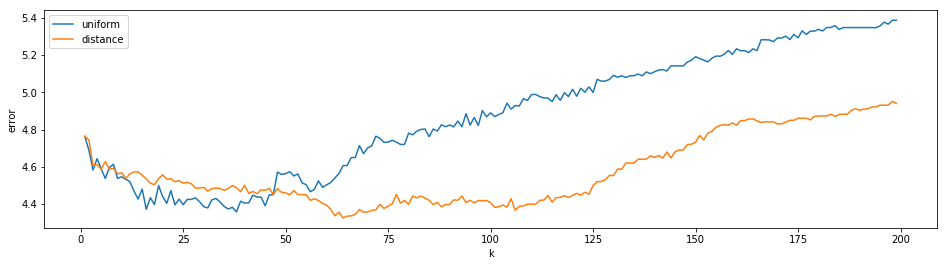

In [15]:
fig, ax = plt.subplots()
for w in W:
    ax.plot(K, errors[w])
ax.set_xlabel('k')
ax.set_ylabel('error')
ax.legend(W)
fig.set_figwidth(16)

In [16]:
clf = KNeighborsClassifier(n_neighbors = min_k, weights = min_w)

In [17]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=64, p=2,
           weights='distance')

In [18]:
y_test = clf.predict(X_test)

In [19]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [20]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [21]:
if not os.path.exists('./submissions/'):
    os.makedirs('./submissions/')

In [22]:
submission.to_csv('./submissions/04_knn.csv', index = False)

My submission to Kaggle produced a 70.81% test prediction accuracy. 

## Feature selection - forward selection

In [27]:
# Forward selection
pending = list(range(2, 62))
model = []
min_error = sys.float_info.max
while len(pending) > 0:
    
    prev_error = min_error
    min_error = sys.float_info.max
    
    # Model selection (selecting columns)
    for i in tqdm(pending):
        new_model = model + [i]
        
        # Model selection within model selection (selecting K and W)
        minimum = sys.float_info.max
        for w in W:
            for k in K:
                error = k_fold_cross_validation(df_training, folds, new_model, k, w)
                if error < minimum:
                    minimum = error
                    min_k = k
                    min_w = w
        
        if minimum < min_error:
            min_error = minimum
            best_model = new_model
            feature = i
            best_k = min_k
            best_w = min_w
            
    if min_error < prev_error:
        print('Selecting feature ' + df_training.columns[feature] + ' - error decreased to ' + str(min_error))
        model = best_model
        pending.remove(feature)
    else:
        print('END')
        break

100%|██████████| 60/60 [18:58<00:00, 18.07s/it]


Selecting feature Sex_male - error decreased to 4.328105960328346


100%|██████████| 59/59 [18:17<00:00, 18.30s/it]


Selecting feature Fare - error decreased to 3.9309842986379477


 29%|██▉       | 17/58 [05:35<14:05, 20.62s/it]

KeyboardInterrupt: 

In [ ]:
# TODO: print best k and best w at each iteration

In [ ]:
# generating sets for 10-fold cross validation
indexes = list(range(len(df_training)))
random.shuffle(indexes)
folds = []
for i in range(10):
    folds.append([])
for i in range(len(indexes)):
    folds[i % 10].append(indexes[i])

In [ ]:
def produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes):
    columns = df_training.columns[column_indexes]
    datasets = {}
    datasets['X_train'] = df_training.iloc[train_indexes][columns].values
    datasets['X_test'] = df_training.iloc[test_indexes][columns].values
    datasets['y_train'] = df_training.iloc[train_indexes]['Survived'].values
    datasets['y_test'] = df_training.iloc[test_indexes]['Survived'].values
    
    return datasets

In [ ]:
def evaluate(datasets, C = None):
    if C is None:
        C = 1
    logreg = LogisticRegression(C = C)
    logreg.fit(datasets['X_train'], datasets['y_train'])
    y_pred = logreg.predict(datasets['X_test'])
    return sqrt(np.sum(np.power(np.array(y_pred) - np.array(datasets['y_test']), 2)))

In [ ]:
def k_fold_cross_validation(df_training, folds, column_indexes, C = None):
    error = 0
    
    for k in range(10):
        train_indexes = []
        for j in range(10):
            if j == k:
                test_indexes = folds[j]
            else:
                train_indexes = train_indexes + folds[j]
                
        datasets = produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes)
        
        error = error + evaluate(datasets, C)
        
    return error / 10.0

In [ ]:
column_indexes = list(range(2, 62))
k_fold_cross_validation(df_training, folds, column_indexes)

In [ ]:
# Forward selection
pending = list(range(2, 62))
model = []
min_error = sys.float_info.max
while len(pending) > 0:
    
    prev_error = min_error
    min_error = sys.float_info.max
    
    for i in pending:
        new_model = model + [i]
        error = k_fold_cross_validation(df_training, folds, new_model)
        
        if error < min_error:
            min_error = error
            best_model = new_model
            feature = i
            
    if min_error < prev_error:
        print('Selecting feature ' + df_training.columns[feature] + ' - error decreased to ' + str(min_error))
        model = best_model
        pending.remove(feature)
    else:
        print('END')
        break

In [ ]:
model_forward = model
columns = df_training.columns[model_forward]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_test = logreg.predict(X_test)

In [ ]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [ ]:
submission.head()

In [ ]:
submission.to_csv('./submissions/02_logistic_regression_forward_selection.csv', index = False)

This submission produced a 75.119% test prediction accuracy

## Forward selection - bakward elimination

In [ ]:
# backward elimination
model = list(range(2, 62))
min_error = k_fold_cross_validation(df_training, folds, column_indexes)
while len(model) > 0:
    
    prev_error = min_error
    min_error = sys.float_info.max
    
    for i in model:
        new_model = model[:]
        new_model.remove(i)
        error = k_fold_cross_validation(df_training, folds, new_model)
        
        if error < min_error:
            min_error = error
            best_model = new_model
            feature = i
            
    if min_error < prev_error:
        print('Removing feature ' + df_training.columns[feature] + ' - error decreased to ' + str(min_error))
        model = best_model
    else:
        print('END')
        break

Backward eliminiation seems to reduce the prediction error for the training set even more. Let's make a submission

In [ ]:
model_backward = model
columns = df_training.columns[model_backward]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_test = logreg.predict(X_test)

In [ ]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [ ]:
submission.head()

In [ ]:
submission.to_csv('./submissions/02_logistic_regression_backward_elimination.csv', index = False)

This submission produced 73.205% prediction accuracy for the test set. Therefore, we should keep forward selection. 

## Model selection - regularisation

The only parameter worth playing with is the regularisation factor C.

In [ ]:
column_indexes = model_forward

In [ ]:
C = np.arange(0.01, 1.5, 0.01)
rmses = []
for c in C:
    rmses.append(k_fold_cross_validation(df_training, folds, new_model, c))

In [ ]:
fig, ax = plt.subplots()
ax.plot(C, rmses)
ax.set_xlabel('C')
ax.set_ylabel('RMSE')
ax.set_title('Regularisation factor - model selection')

Minimum seems to be at 0.7

In [ ]:
columns = df_training.columns[model_forward]
X_train = df_training[columns].values
X_test = df_test[columns].values
y_train = df_training['Survived'].values

In [ ]:
logreg = LogisticRegression(C = 0.7)

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_test = logreg.predict(X_test)

In [ ]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [ ]:
submission.head()

In [ ]:
submission.to_csv('./submissions/02_logistic_regression_regularisation.csv', index = False)

I obtained exactly the same test accuracy after my submission than in the case of not using regularisation.